# 📊 Segmentação de Clientes com Análise RFM e Clustering

Este projeto simula o trabalho de um analista de dados em uma empresa britânica de e-commerce que vende presentes exclusivos. O objetivo é aplicar técnicas de segmentação de clientes com base em dados transacionais coletados entre dezembro de 2010 e dezembro de 2011.

Com a análise, buscamos apoiar as áreas de Marketing, Vendas e Produtos a tomarem decisões estratégicas personalizadas para cada perfil de cliente.

## 🧠 Entendimento do Negócio e Objetivo

A empresa fictícia deste projeto é um e-commerce britânico especializado na venda de presentes exclusivos. Ela opera majoritariamente online, com uma grande base de clientes B2B (atacadistas). O negócio precisa entender melhor seus clientes para personalizar ações de marketing, promoções e campanhas de fidelização.

### 🎯 Objetivo do Projeto

O objetivo principal é aplicar **análise RFM (Recência, Frequência, Valor Monetário)** e técnicas de **clusterização** para segmentar os clientes com base no comportamento de compra.

Com esses segmentos, as áreas de **Marketing**, **Vendas** e **Produtos** poderão tomar decisões estratégicas e personalizadas com base nos perfis identificados.


In [28]:
# Bloco 1: Instalar biblioteca squarify para o gráfico treemap
#!pip install squarify

In [29]:
# Bloco 2: Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
import os
import squarify
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')

In [30]:
# Bloco 3: Carregar o arquivo CSV (ajuste o caminho se necessário)
try:
    df = pd.read_csv("Online Retail.csv", encoding='ISO-8859-1', sep=',')
    print("Arquivo 'Online Retail.csv' carregado com sucesso.")
except FileNotFoundError:
    print("Erro: Arquivo 'Online Retail.csv' não encontrado.")
    print("Certifique-se de que o arquivo está no mesmo diretório do notebook ou forneça o caminho completo.")
    df = None # Define df como None para evitar erros nas células seguintes se o arquivo não for carregado

if df is not None:
    # Conversão da coluna de datas
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    print("\nPrimeiras linhas do DataFrame:")
    print(df.head())

Arquivo 'Online Retail.csv' carregado com sucesso.

Primeiras linhas do DataFrame:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [31]:
# Bloco 4: Cria a pasta 'imagens' se ela não existir
if not os.path.exists("imagens"):
    os.makedirs("imagens")
    print("Pasta 'imagens' criada.")
else:
    print("Pasta 'imagens' já existe.")

Pasta 'imagens' já existe.


In [32]:
# Bloco 5: Pré-processamento e Limpeza dos Dados
if df is not None:
    print(f"Tamanho original: {df.shape}")
    # Remover linhas com CustomerID nulo, essencial para RFM
    df.dropna(subset=['CustomerID'], inplace=True)
    print(f"Tamanho após remover CustomerID nulo: {df.shape}")

    # Remover transações canceladas (InvoiceNo começando com 'C')
    df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
    print(f"Tamanho após remover cancelados: {df.shape}")

    # Remover linhas onde Quantidade ou Preço Unitário são negativos ou zero (se apropriado)
    df = df[df['Quantity'] > 0]
    df = df[df['UnitPrice'] > 0]
    print(f"Tamanho após remover Quantidade/Preço Unitário <= 0: {df.shape}")

    # Converter CustomerID para inteiro (após remover nulos)
    df['CustomerID'] = df['CustomerID'].astype(int)

    print("\nDataFrame após limpeza inicial:")
    print(df.head())
else:
    print("DataFrame não carregado. Pulando limpeza.")

Tamanho original: (541909, 8)
Tamanho após remover CustomerID nulo: (406829, 8)
Tamanho após remover cancelados: (397924, 8)
Tamanho após remover Quantidade/Preço Unitário <= 0: (397884, 8)

DataFrame após limpeza inicial:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55       17850  United Kingdom  
1 2010-12-01 08:26:00       3.39       17850  United Kingdom  
2 2010-12-01 08:26:00       2.75       17850  United Kingdom  
3 2010-12-01 08:26:00       3.39       17850  United Kingdom  
4 2010-12-01 08:26:00       3

In [33]:
# Bloco 6: Criar coluna TotalGasto
if df is not None:
    df['TotalGasto'] = df['Quantity'] * df['UnitPrice']
    print("\nDataFrame com a coluna 'TotalGasto':")
    print(df.head())
else:
    print("DataFrame não carregado. Pulando cálculo de TotalGasto.")


DataFrame com a coluna 'TotalGasto':
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalGasto  
0 2010-12-01 08:26:00       2.55       17850  United Kingdom       15.30  
1 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34  
2 2010-12-01 08:26:00       2.75       17850  United Kingdom       22.00  
3 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34  
4 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34  


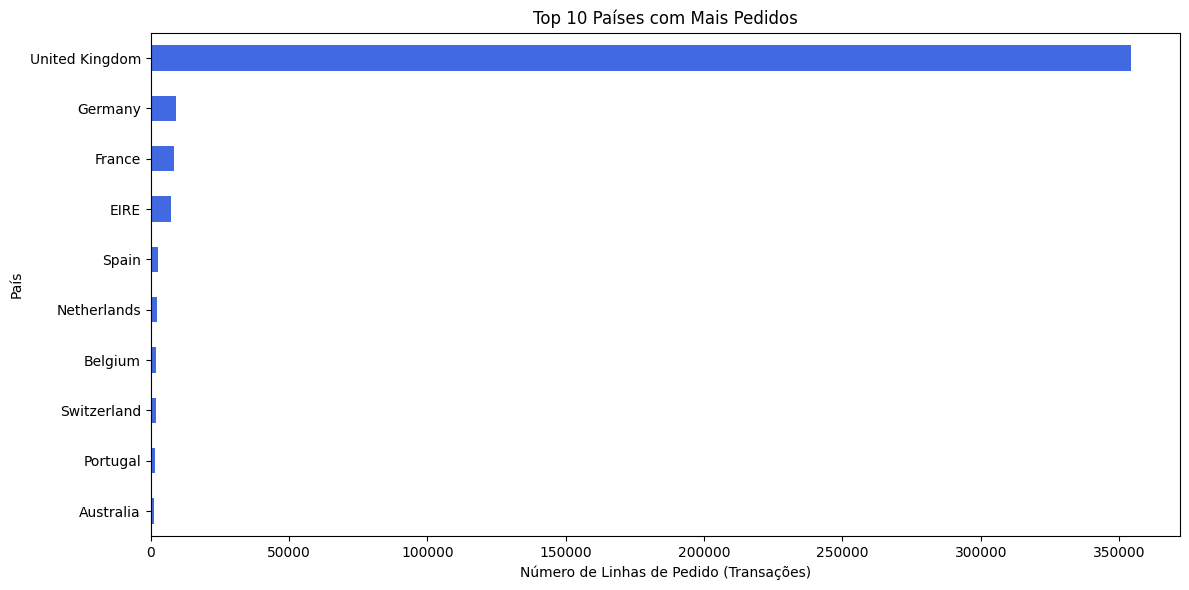

In [34]:
# Bloco 7: Análise Exploratória - Top 10 Países com Mais Pedidos
if df is not None:
    pedidos_pais = df['Country'].value_counts()

    plt.figure(figsize=(12, 6))
    pedidos_pais[:10].plot(kind='barh', color='royalblue')
    plt.title('Top 10 Países com Mais Pedidos')
    plt.xlabel('Número de Linhas de Pedido (Transações)')
    plt.ylabel('País')
    plt.gca().invert_yaxis() # O país com mais pedidos fica no topo

    # Salvar gráfico
    plt.tight_layout()
    plt.savefig('imagens/pedidos_por_pais.png')
    plt.show()
else:
    print("DataFrame não carregado. Pulando gráfico de pedidos por país.")

In [35]:
# Bloco 8: Cálculo dos valores de Recência, Frequência e Monetário
if df is not None:
    # Data de referência para recência (um dia após a última data no dataset)
    data_ref = df['InvoiceDate'].max() + dt.timedelta(days=1)
    print(f"Data de referência para cálculo da Recência: {data_ref.strftime('%Y-%m-%d')}")

    # Agrupamento por Cliente para calcular R, F, M
    rfm = df.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (data_ref - x.max()).days,  # Recência
        'InvoiceNo': 'nunique',                             # Frequência (número de pedidos únicos)
        'TotalGasto': 'sum'                                 # Valor Monetário
    })

    # Renomear colunas
    rfm.columns = ['Recencia', 'Frequencia', 'ValorMonetario']

    # Remover possíveis clientes com valor monetário zero ou negativo (embora já filtrado antes)
    rfm = rfm[rfm['ValorMonetario'] > 0]
    print(f"\nTamanho do DataFrame RFM: {rfm.shape}")

    print("\nDataFrame RFM calculado:")
    print(rfm.head())
else:
    print("DataFrame original não carregado. Pulando cálculo RFM.")

Data de referência para cálculo da Recência: 2011-12-10

Tamanho do DataFrame RFM: (4338, 3)

DataFrame RFM calculado:
            Recencia  Frequencia  ValorMonetario
CustomerID                                      
12346            326           1        77183.60
12347              2           7         4310.00
12348             75           4         1797.24
12349             19           1         1757.55
12350            310           1          334.40


In [36]:
# Bloco 9: Calcular Scores RFM (usando quartis)
if 'rfm' in locals() and rfm is not None:
    # Criar quantis (usando quartis - 4 grupos)
    quantiles = rfm[['Recencia', 'Frequencia', 'ValorMonetario']].quantile(q=[0.25, 0.5, 0.75]).to_dict()

    # Funções para atribuir scores R, F, M
    def r_score(x, p, d):
        if x <= d[p][0.25]: return 4
        elif x <= d[p][0.50]: return 3
        elif x <= d[p][0.75]: return 2
        else: return 1

    def fm_score(x, p, d):
        if x <= d[p][0.25]: return 1
        elif x <= d[p][0.50]: return 2
        elif x <= d[p][0.75]: return 3
        else: return 4

    # Calcular colunas de scores R, F, M
    rfm['R'] = rfm['Recencia'].apply(r_score, args=('Recencia', quantiles,))
    rfm['F'] = rfm['Frequencia'].apply(fm_score, args=('Frequencia', quantiles,))
    rfm['M'] = rfm['ValorMonetario'].apply(fm_score, args=('ValorMonetario', quantiles,))

    print("DataFrame RFM com Scores R, F, M adicionados:")
    print(rfm.head())
else:
    print("DataFrame RFM não calculado. Pulando cálculo de Scores.")

DataFrame RFM com Scores R, F, M adicionados:
            Recencia  Frequencia  ValorMonetario  R  F  M
CustomerID                                               
12346            326           1        77183.60  1  1  4
12347              2           7         4310.00  4  4  4
12348             75           4         1797.24  2  3  4
12349             19           1         1757.55  3  1  4
12350            310           1          334.40  1  1  2


In [37]:
# Bloco 10: Definir Segmentos RFM e adicionar coluna 'Segmento'
if 'rfm' in locals() and rfm is not None:
    # Função para mapear scores R e F para nomes de segmentos
    def assign_segment(row):
        if row['R'] >= 4 and row['F'] >= 4: return 'Campeões'
        elif row['R'] >= 3 and row['F'] >= 3: return 'Fiéis'
        elif row['R'] >= 4 and row['F'] <= 2: return 'Novos/Promissores'
        elif row['R'] <= 2 and row['F'] >= 3: return 'Em Risco'
        elif row['R'] <= 2 and row['F'] <= 2: return 'Hibernando/Perdidos'
        elif row['R'] == 3 and row['F'] <= 2: return 'Atenção Necessária'
        else: return 'Outros'

    # Aplicar a função para criar a coluna 'Segmento'
    rfm['Segmento'] = rfm.apply(assign_segment, axis=1)

    print("\nDataFrame RFM com a coluna 'Segmento':")
    print(rfm.head())

    # Verificar a contagem de clientes em cada segmento
    print("\nDistribuição dos Clientes por Segmento:")
    print(rfm['Segmento'].value_counts())
else:
    print("DataFrame RFM não disponível. Pulando definição de segmentos.")


DataFrame RFM com a coluna 'Segmento':
            Recencia  Frequencia  ValorMonetario  R  F  M             Segmento
CustomerID                                                                    
12346            326           1        77183.60  1  1  4  Hibernando/Perdidos
12347              2           7         4310.00  4  4  4             Campeões
12348             75           4         1797.24  2  3  4             Em Risco
12349             19           1         1757.55  3  1  4   Atenção Necessária
12350            310           1          334.40  1  1  2  Hibernando/Perdidos

Distribuição dos Clientes por Segmento:
Segmento
Hibernando/Perdidos    1589
Fiéis                   920
Em Risco                561
Campeões                529
Atenção Necessária      471
Novos/Promissores       268
Name: count, dtype: int64


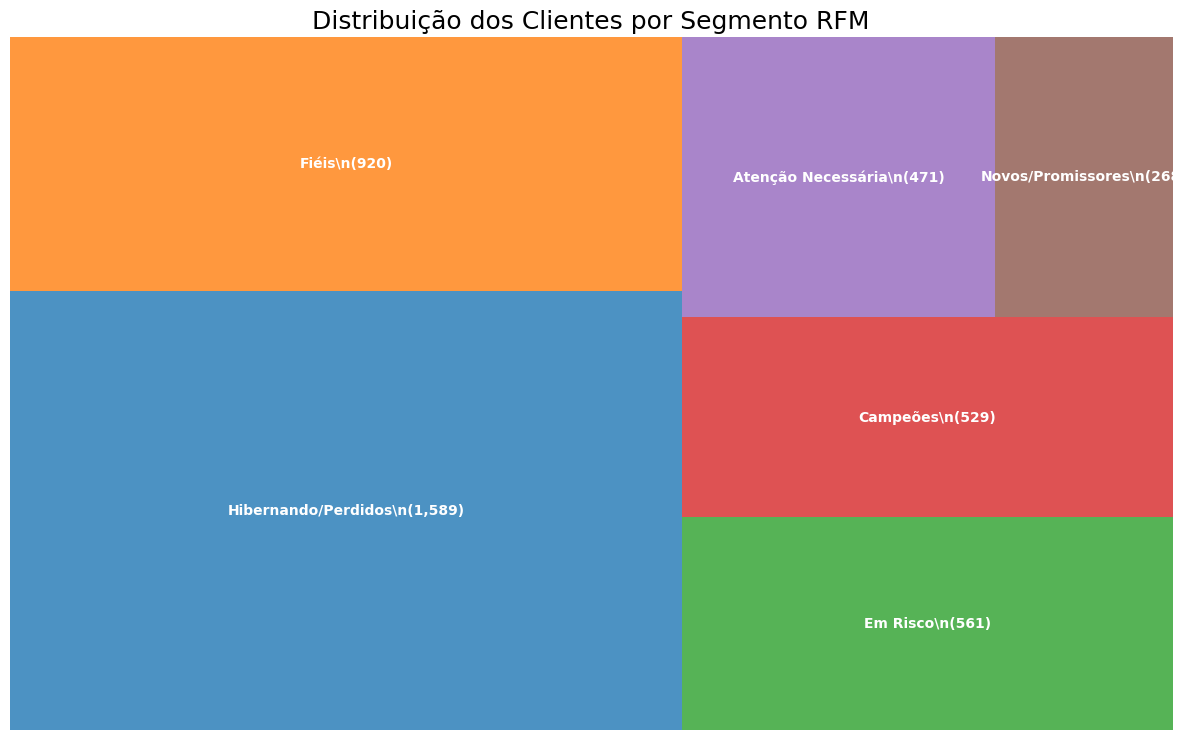

In [38]:
# Bloco 11: Visualizar Segmentos com Treemap
if 'rfm' in locals() and rfm is not None:
    # Contagem de clientes por segmento
    segment_counts = rfm['Segmento'].value_counts().reset_index()
    segment_counts.columns = ['Segmento', 'Contagem']

    # Ordenar segmentos por contagem para melhor visualização no treemap
    segment_counts = segment_counts.sort_values(by='Contagem', ascending=False)

    # Gerar cores automaticamente usando uma paleta Seaborn
    num_segments = len(segment_counts['Segmento'])
    colors = sns.color_palette('tab10', num_segments)

    # Mapear segmentos para cores
    segment_color_map = dict(zip(segment_counts['Segmento'], colors))
    plot_colors_sorted = [segment_color_map[seg] for seg in segment_counts['Segmento']]

    # Gráfico treemap
    plt.figure(figsize=(15, 9))
    squarify.plot(sizes=segment_counts['Contagem'],
                  label=[f"{seg}\\n({cont:,})" for seg, cont in zip(segment_counts['Segmento'], segment_counts['Contagem'])],
                  color=plot_colors_sorted,
                  alpha=0.8,
                  text_kwargs={'fontsize':10, 'color':'white', 'weight':'bold'}
                 )

    plt.title("Distribuição dos Clientes por Segmento RFM", fontsize=18)
    plt.axis('off')

    # Salvar gráfico na pasta 'imagens'
    plt.savefig('imagens/segmentacao_rfm_treemap.png', dpi=300, bbox_inches='tight')

    plt.show()
else:
    print("DataFrame RFM não disponível. Pulando gráfico Treemap.")

In [39]:
# Bloco 12: Clusterização K-Means (Como estava no notebook original, pode ser complementar ou alternativo à segmentação por score)
if 'rfm' in locals() and rfm is not None:
    # Selecionar apenas as colunas numéricas originais do RFM para normalização
    rfm_features = rfm[['Recencia', 'Frequencia', 'ValorMonetario']]

    scaler = StandardScaler()
    rfm_normalizado = scaler.fit_transform(rfm_features)

    # Treinando com 4 clusters (pode-se usar o método do cotovelo para escolher k)
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10) # n_init=10 é o padrão e suprime warnings
    kmeans.fit(rfm_normalizado)

    # Adiciona coluna de cluster ao DataFrame RFM original (rfm)
    rfm['Cluster_KMeans'] = kmeans.labels_

    print("\nDataFrame RFM com coluna 'Cluster_KMeans':")
    print(rfm.head())

    # Analisar as características médias de cada cluster KMeans
    print("\nAnálise dos Clusters K-Means (Médias):")
    cluster_analysis_kmeans = rfm.groupby('Cluster_KMeans').agg({
        'Recencia': 'mean',
        'Frequencia': 'mean',
        'ValorMonetario': ['mean', 'count'] # Adiciona contagem
    }).round(1)
    print(cluster_analysis_kmeans)
else:
    print("DataFrame RFM não disponível. Pulando Clusterização K-Means.")


DataFrame RFM com coluna 'Cluster_KMeans':
            Recencia  Frequencia  ValorMonetario  R  F  M  \
CustomerID                                                  
12346            326           1        77183.60  1  1  4   
12347              2           7         4310.00  4  4  4   
12348             75           4         1797.24  2  3  4   
12349             19           1         1757.55  3  1  4   
12350            310           1          334.40  1  1  2   

                       Segmento  Cluster_KMeans  
CustomerID                                       
12346       Hibernando/Perdidos               3  
12347                  Campeões               0  
12348                  Em Risco               0  
12349        Atenção Necessária               0  
12350       Hibernando/Perdidos               1  

Análise dos Clusters K-Means (Médias):
               Recencia Frequencia ValorMonetario      
                   mean       mean           mean count
Cluster_KMeans            